In [1]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import numpy as np

import jabble.dataset
import jabble.loss
import jabble.model

import sys 
sys.path.insert(0,'/home/mdd423/WobbleSim/')
import simulacra.dataset
import pickle

<h1>Intro to Jabble: Fitting EPRVs from Simulacra</h1>
This notebook will give you an introduction to how jabble work by fitting to a dataset generate by Simulacra. Where the EPRVs are precisely known and can be checked for accuracy

In [2]:
data    = simulacra.dataset.from_h5('../WobbleSim/out/datatest5.h5')
epoches = data['data']['flux'].shape[0]

<HDF5 dataset "obs_times": shape (30,), type "|O">


In [3]:
masks = np.zeros(data['data']['flux'].shape,dtype=bool)
wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
flux = np.array(data['data']['flux'])
ferr = np.array(data['data']['ferr'])

In [4]:
wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks)

In [7]:
import astropy.time as at
import astropy.coordinates as coord

In [22]:
obs_times = data['data']['obs_times']
exp_times = data['data']['exp_times']
times = at.Time(obs_times + exp_times/2)

In [23]:
loc    = data['parameters']['detector']['loc']
target = data['parameters']['star']['target']
period = data['parameters']['star']['period']

In [24]:
loc    = coord.EarthLocation.from_geocentric(loc.value[0] * loc.unit,loc.value[1] * loc.unit,loc.value[2] * loc.unit)
target = coord.SkyCoord(86.34748103 * u.deg, 33.67001499 * u.deg)
print(target)
print(coord.SkyCoord.from_name('hat-p-20'))

<SkyCoord (ICRS): (ra, dec) in deg
    (86.34748103, 33.67001499)>
<SkyCoord (ICRS): (ra, dec) in deg
    (111.91645309, 24.33653285)>


In [25]:
bc   = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
init_shifts = jabble.dataset.shifts(bc)

In [26]:
rvs = data['data']['rvs']

In [27]:
import matplotlib.pyplot as plt

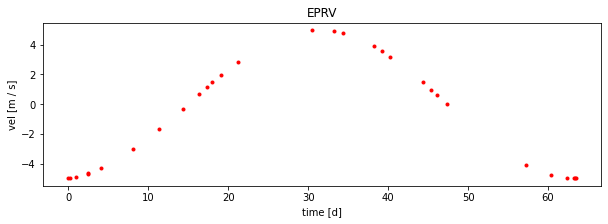

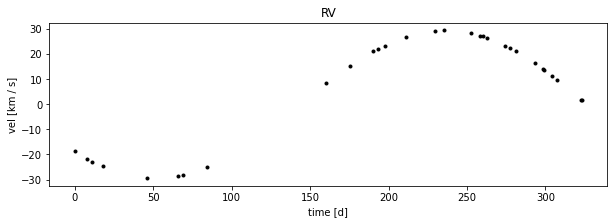

In [28]:
rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s
plt.plot((times - min(times)).to(u.day).value % period.to(u.day).value,eprv.to(v_unit).value,'.r')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot((times - min(times)).to(u.day).value,rv.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

the mitochondrdia is the powehouse of the cell

In [29]:
loss = jabble.loss.ChiSquare()

In [30]:
import astropy.constants as const
wave_grid = data['parameters']['detector']['wave_grid']
x_grid    = np.log(wave_grid.to(u.Angstrom).value)
vel_padding = 30 * u.m/u.s

In [31]:
# x_grid = jabble.model.create_x_grid(wob_data.xs,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])
stellar_model.fit(1)

In [32]:
maxiter = 32
res = stellar_model.optimize(loss,wob_data,maxiter)

[ Value: 6.26e+20 ]
[ Value: 3.48e+20 ]
[ Value: 2.26e+20 ]
[ Value: 2.08e+20 ]
[ Value: 9.44e+19 ]
[ Value: 7.09e+19 ]
[ Value: 6.83e+19 ]
[ Value: 6.76e+19 ]
[ Value: 6.62e+19 ]
[ Value: 6.51e+19 ]
[ Value: 6.48e+19 ]
[ Value: 6.47e+19 ]
[ Value: 6.45e+19 ]
[ Value: 6.44e+19 ]
[ Value: 6.43e+19 ]
[ Value: 6.42e+19 ]
[ Value: 6.42e+19 ]
[ Value: 6.41e+19 ]
[ Value: 6.41e+19 ]
[ Value: 6.40e+19 ]
[ Value: 6.39e+19 ]
[ Value: 6.38e+19 ]
[ Value: 6.37e+19 ]
[ Value: 6.36e+19 ]
[ Value: 6.35e+19 ]
[ Value: 6.34e+19 ]
[ Value: 6.34e+19 ]
[ Value: 6.34e+19 ]
[ Value: 6.34e+19 ]
[ Value: 6.33e+19 ]
[ Value: 6.33e+19 ]
[ Value: 6.33e+19 ]
[ Value: 6.32e+19 ]


In [33]:
print(res)

      fun: array(6.32374877e+19)
 hess_inv: <80675x80675 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.44045169e+12, -3.21445324e+12, -5.08356094e+12, ...,
       -5.88444750e+16, -6.60484194e+16,  6.04256338e+17])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 33
      nit: 32
     njev: 33
   status: 1
  success: False
        x: array([7.71751167e-05, 2.93502217e-05, 4.64133171e-05, ...,
       1.61146147e+00, 1.64922706e+00, 1.98595129e+00])


In [34]:
import matplotlib.pyplot as plt

(8.712759974960212, 9.210340371976184)

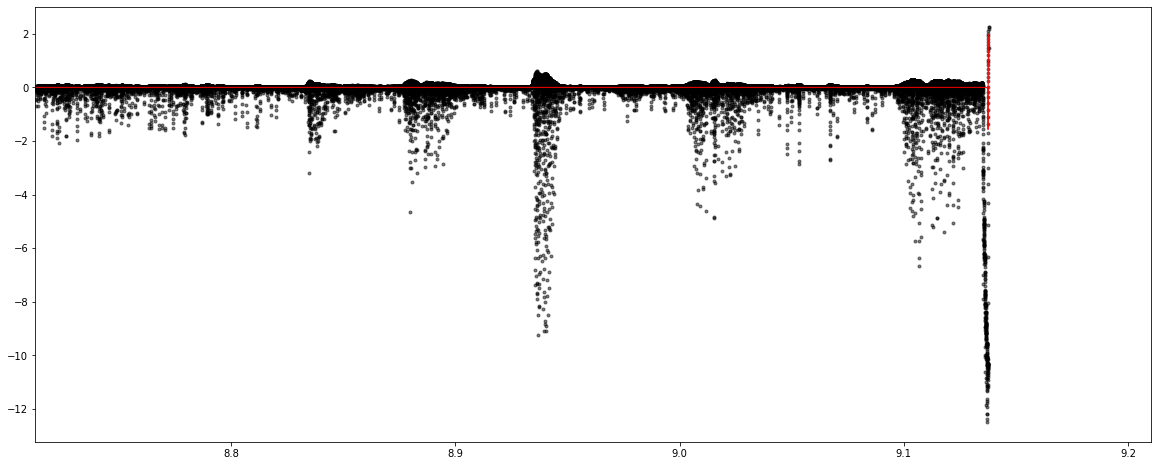

In [35]:
epoch_idx = 4
xpmin = np.log(6080)
xpmax = np.log(10000)

plt.figure(figsize=(20,8))
plt.errorbar(wob_data.xs[epoch_idx,:],wob_data.ys[epoch_idx,:],wob_data.yerr[epoch_idx,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
plt.plot(stellar_model[1].xs-stellar_model[0].p[epoch_idx],stellar_model[1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
plt.xlim(xpmin,xpmax)

In [ ]:
vel_width = 100 * u.km/u.s

In [ ]:
velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,const.c.to(u.km/u.s).value/resolution)*u.km/u.s
velocity_grid = np.add.outer(init_vels,velocity_kern)

shift_grid = jabble.dataset.shifts(velocity_grid)
loss_array = stellar_model[0].grid_search(shift_grid,loss,stellar_model,wob_data)

In [ ]:
x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)
stellar_model[0].p = x_min

In [ ]:
velocity_kern.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
epoch_idx = 0
plt.plot(shift_grid[epoch_idx,:],loss_array[epoch_idx,:],'*k')

In [ ]:
stellar_model.fit(0)
stellar_model.fit(1)
maxiter = 32
res = stellar_model.optimize(loss,wob_data,maxiter)

In [ ]:
final_vels = jabble.dataset.velocityfromshift(stellar_model[0].p)

In [ ]:
plt.plot((times - min(times)).to(u.day).value % period,rvs-init_vels,'*k')
plt.plot((times - min(times)).to(u.day).value % period,final_vels-init_vels,'*r')
# plt.ylim(-1,1)